In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
def display_image(image):
    
    plt.figure(figsize = (8,8))
    plt.imshow(image,cmap = "gray")
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()
    
def convert_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [32]:
def getContours(image,cThr = [100,100],showCanny = False,minArea = 1000,filter = 0,draw = False):
    
    imgGray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgCanny = cv2.Canny(imgBlur,cThr[0],cThr[1])
    kernel = np.ones((5,5))
    imgDial = cv2.dilate(imgCanny,kernel,iterations = 3)
    imgErode = cv2.erode(imgDial,kernel,iterations = 2)
    
    if showCanny:
        #cv2.imshow("Canny",imgErode) 
        display_image(imgErode)
        
    contours, hiearchy = cv2.findContours(imgErode,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    finalContours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > minArea:
            peri = cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt,0.02*peri,True)
            bbox = cv2.boundingRect(approx)
            #print(approx.shape)
            if filter > 0:       
                if len(approx) == filter:
                    finalContours.append([len(approx),area,approx,bbox,cnt])
            else:
                finalContours.append([len(approx),area,approx,bbox,cnt])
    
    # En büyük istiyoruz !!! 
    finalContours = sorted(finalContours,key = lambda x : x[1], reverse = True)
    if draw:
        for con in finalContours:
            cv2.drawContours(image,con[4],-1,(0,0,255),5)
            
    return image,finalContours

In [5]:
def reorder(myPoints,detail = False):

    myPointsNew = np.zeros_like(myPoints)
    
    # Normalde (4,1,2) çıkıyor !!!
    myPoints = myPoints.reshape((4,2))
    add = myPoints.sum(1)
    
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    
    diff = np.diff(myPoints,axis = 1)
    
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    
    if detail:

        print("ReOrder : ", myPoints.shape)
        print("myPoints : \n",myPoints )
        print("Add : \n",add)
        print("Diff : \n",diff)

    return myPointsNew

def warpImg(image,points,w,h,pad = 20):
        
    pts1 = np.float32(points)
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarp = cv2.warpPerspective(image, matrix, (w,h))
    imgWarp = imgWarp[pad : imgWarp.shape[0] - pad, pad : imgWarp.shape[1] - pad]

    return imgWarp

def findDis(pts1,pts2):
    return ((pts2[0]-pts1[0])**2 + (pts2[1]-pts1[1])**2)**0.5

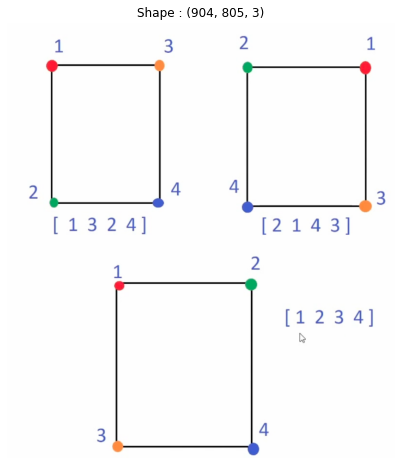

In [6]:
reorder_img = cv2.imread("/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/reorder.png")
display_image(convert_rgb(reorder_img))

In [7]:
test = np.array([[[378 ,145]],[[ 76, 150]],[[ 37 ,592]], [[414 ,592]]])
print("Test Shape :", test.shape)

results = reorder(test,detail = True)
print("".center(50,"-"))
print(test)  
print("".center(50,"-"))
print(results)

Test Shape : (4, 1, 2)
ReOrder :  (4, 2)
myPoints : 
 [[378 145]
 [ 76 150]
 [ 37 592]
 [414 592]]
Add : 
 [ 523  226  629 1006]
Diff : 
 [[-233]
 [  74]
 [ 555]
 [ 178]]
--------------------------------------------------
[[[378 145]]

 [[ 76 150]]

 [[ 37 592]]

 [[414 592]]]
--------------------------------------------------
[[[ 76 150]]

 [[378 145]]

 [[ 37 592]]

 [[414 592]]]


In [8]:
scale = 3
round((findDis(results[0][0] // scale , results[1][0] // scale) / 10),1)

10.1

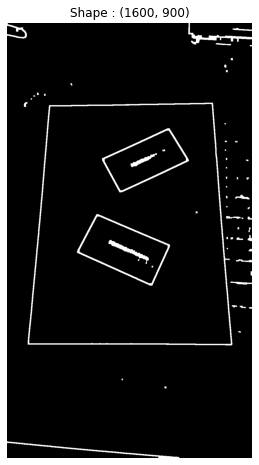

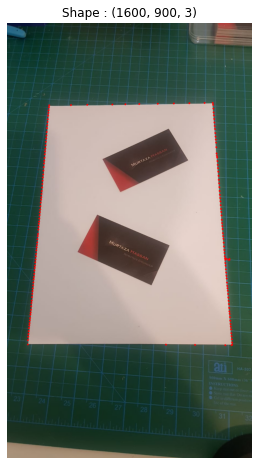

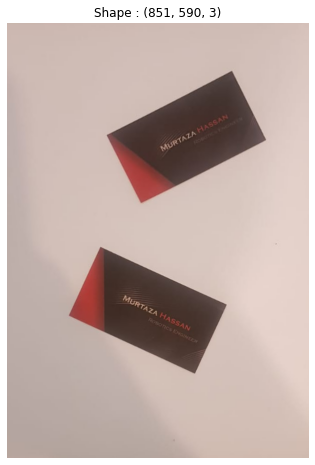

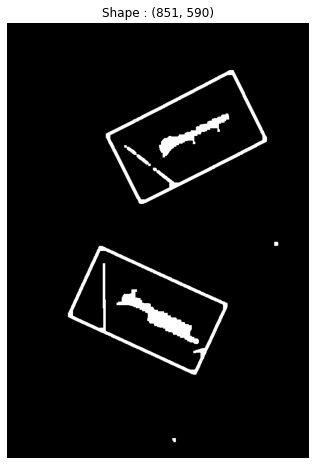

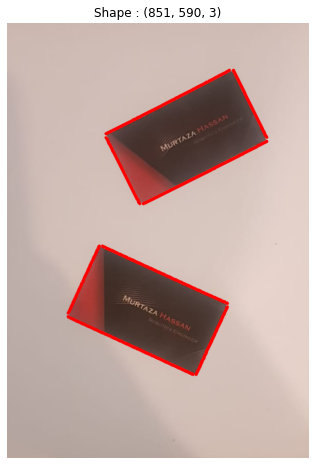

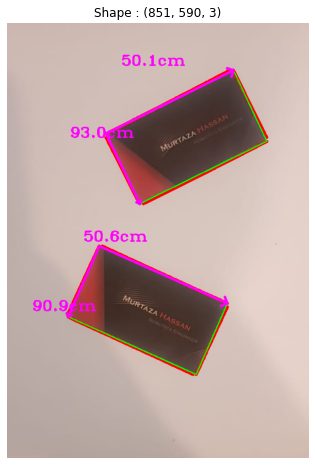

In [35]:
path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/twocards.jpeg"

scale = 3
wP = 210 * scale
hP = 297 * scale
img_ = cv2.imread(path)

img,conts=getContours(img_,showCanny=True,draw=True,filter = 4,minArea = 50000)

for obj in conts:
    points = obj[2]
    re_conts_ = reorder(points)
    imgWarp_ = warpImg(img,re_conts_,wP,hP,pad = 20) 

display_image(convert_rgb(img))
display_image(convert_rgb(imgWarp_))

img2,conts2=getContours(imgWarp_,showCanny=True,draw=True,filter = 4,minArea = 1000,cThr = [50,50])
display_image(convert_rgb(imgWarp_))

for obj in conts2:
    cv2.polylines(img2,[obj[2]],True,(0,255,0),2)
    nPoints = reorder(obj[2])
    nH = round(findDis(nPoints[0][0] // scale,nPoints[1][0] // scale),1)
    nW = round(findDis(nPoints[0][0] // scale,nPoints[2][0] // scale),1)
    cv2.arrowedLine(img2, 
                    (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[1][0][0], nPoints[1][0][1]),
                    (255, 0, 255), 3, 8, 0, 0.05)
    cv2.arrowedLine(img2, 
                    (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[2][0][0], nPoints[2][0][1]),
                    (255, 0, 255), 3, 8, 0, 0.05)
    x, y, w, h = obj[3]
    cv2.putText(img2, '{}cm'.format(nW), (x + 30, y - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (255, 0, 255), 2)
    cv2.putText(img2, '{}cm'.format(nH), (x - 70, y + h // 2), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (255, 0, 255), 2)
display_image(convert_rgb(img2))

In [40]:
webcam = False
path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/twocards.jpeg"
cap = cv2.VideoCapture(0)
cap.set(10,160)
cap.set(3,1920)
cap.set(4,1080)

scale = 3
wP = 210 * scale
hP = 297 * scale


while True:
    
    if webcam:
        conn,img = cap.read()
        
    else:
        img = cv2.imread(path)
        
    #conts --- > [len(approx),area,approx,bbox,cnt]
    imgContours, conts = getContours(img,
                                     showCanny = False,
                                     minArea = 50000,
                                     filter = 4,
                                     draw = False) # Contours çizdirmedik !!
    
    if len(conts) != 0:
        # approx
        biggest = conts[0][2]
        #print(biggest.shape)
        biggest_ = reorder(biggest,detail = False)
        imgWarp = warpImg(img,biggest_,wP,hP,pad = 10)
        imgContours2, conts2 = getContours(imgWarp,
                                           showCanny = False,
                                           minArea = 1000,
                                           filter = 4,
                                           cThr = [50,50],
                                           draw = True)
        
        if len(conts) != 0:
            for obj in conts2:
                cv2.polylines(imgContours2,[obj[2]],True,(0,255,0),2)
                #print(np.array(obj[2]).shape)
                nPoints = reorder(obj[2])
                nH = round(findDis(nPoints[0][0] // scale,nPoints[1][0] // scale) / 10,1)
                nW = round(findDis(nPoints[0][0] // scale,nPoints[2][0] // scale) / 10,1)
                cv2.arrowedLine(imgContours2, 
                                (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[1][0][0], nPoints[1][0][1]),
                                (255, 0, 255), 3, 8, 0, 0.05)
                cv2.arrowedLine(imgContours2, 
                                (nPoints[0][0][0], nPoints[0][0][1]), (nPoints[2][0][0], nPoints[2][0][1]),
                                (255, 0, 255), 3, 8, 0, 0.05)
                
                x, y, w, h = obj[3]
                cv2.putText(imgContours2, '{}cm'.format(nW), (x + 30, y - 10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (255, 0, 255), 2)
                cv2.putText(imgContours2, '{}cm'.format(nH), (x - 70, y + h // 2), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5,
                            (255, 0, 255), 2)
                
        cv2.imshow("Original Wrap Draw",imgContours2)
    
    img = cv2.resize(img,(0,0),None,0.5,0.5)
    cv2.imshow("Original",img)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
          
cap.release()
cv2.destroyAllWindows()